# Demo: Analyzing Log Analytics DAta with Azure Log Reader App Client Secret authentication

-   Author: Julie Koesmarno ([@MsSQLGirl](http://twitter.com/MsSQLgirl))
-   Last updated: Nov 8, 2020

This notebook also serves as an example of a **parameterized** notebook. Based on the parameters, the notebook will connect to Log Analytics based on a Log Anaytics connection file and execute queries. In the examples below, the Log Analytics workspace I'm using here, stores Azure SQL log data. 

### **Parameters (variables)**

1. laConnFile = Provide the file path that contains the Log Analytics workspace connection details.  
    The expected content format in the file is:  
    ```
    tenantId:<your Azure Tenant ID>  
    clientId:<your Log Reader App ID that has Log Analytics Reader access to your Log Analytics workspace>  
    clientSecret:<the Client Secret value of your Log Reader App ID>  
    workspaceId:<the Workspace ID of your Log Analytics worspace>  
    ```
2. showClearText = put `Y` for debugging purposes. The default value is `N`.  

3. laAlias = an alias to your connection. Provide a value here so that the Workspace ID is not printed in clear text. The default value is `myLAConnection`.

4. logicalServerName = this is a parameter that will be passed to the KQL queries to filter AzureDiagnostics table.  

This notebook was wrirten in Azure Data Studio; and can be executed using as is or via papermill. 

### **How to execute?**

There are two ways of running this:
1. For testing purposes, you can run each cell at a time. Modifiying the Parameters code cell to ensure that it works. 
2. For parameterized run, you can use papermill. Here's a notebook on how to do so. 


> **Announcement**: Join my presentation on 28 Nov 2020 at 11:30am SGT on [Kusto Query Language (KQL) in Azure Data Studio](https://www.sqlsaturday.com/1019/Sessions/Details/sid/108601)


### **Pre-requisites**
If you are new to Kqlmagic, the following would be handy for you to get up to speed:

-   [Kqlmagic in Azure Data Studio](https://docs.microsoft.com/sql/azure-data-studio/notebooks/notebooks-kqlmagic) - this explains what Kqlmagic is, how to install, and some of the use cases.
-   [Check Kqlmagic Installation](https://github.com/MsSQLGirl/jubilant-data-wizards/blob/main/Useful%20Notebooks/CheckKqlmagicInstallation.ipynb) - this is the notebook that you can use to follow and install Kqlmagic.
-   Get Azure Data Studio - [http://aka.ms/getAzureDataStudio](http://aka.ms/getAzureDataStudio)

**Let's get started!**

This notebook will show you how to:

1. Define parameters
2. Read Log Analytics connection file
3. Load Kqlmagic extension
4. Connect to the Log Analytics workspace as per the configuration defined in the Log Analtyics connectionfile. 
5. Run some KQL queries
    Example 1: Get 10 rows from AzureDiagnostics with some filters  
    Example 2: Create a timechart  
    Example 3: Summarize Action Name from the AzureDiagnostic table  

Lastly, I've added FAQ section at the end of the notebook, in case you are new to setting up Log Analytics reader app, and/or setting up Log Analytics to capture log / diagnosis for Azure SQL servers/databases.

> **Tip**: Please ensure that this notebook Kernel is set to Python.


## Step 1. Define Parameters

In [1]:
laConnFile = 'c:\Temp\LAConnection.txt'
showClearText = 'N'
laAlias = 'myLAConnection'
logicalServerName = 'myDatabaseName'

## Step 2. Read Log Analytics Connection file

This code will read the file from the path provided. 

> **Note**: you can create an empty txt file with the details below. Replace them with real values of course! :D  
Not sure how to start? Check out The Solution section in this blog post by Dennes Torres: https://www.red-gate.com/simple-talk/blogs/connecting-log-analytics-using-azure-data-studio-kql/

    ```
    tenantId:<your Azure Tenant ID>  
    clientId:<your Log Reader App ID that has Log Analytics Reader access to your Log Analytics workspace>  
    clientSecret:<the Client Secret value of your Log Reader App ID>  
    workspaceId:<the Workspace ID of your Log Analytics worspace>  
    ```

In [2]:
 with open(laConnFile, 'r') as reader:
        tenantId = reader.readline().replace('tenantId:','').rstrip()
        clientId = reader.readline().replace('clientId:','').rstrip()
        clientSecret = reader.readline().replace('clientSecret:','').rstrip()
        workspaceId = reader.readline().replace('workspaceId:','').rstrip()

if showClearText == 'Y' :
        print("tenantId:" + tenantId)
        print("clientId:" + clientId)
        print("clientSecret:" + clientSecret)
        print("workspaceId:" + workspaceId)
else : 
        print("tenantId:XXXX")
        print("clientId:XXXX")
        print("clientSecret:XXXX")
        print("workspaceId:XXXX")

tenantId:XXXX
clientId:XXXX
clientSecret:XXXX
workspaceId:XXXX


## Step 3. Load Kqlmagic extension


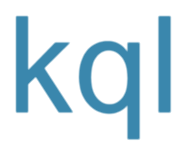

In [3]:
%reload_ext Kqlmagic

## Step 4. Connect to the Log Analytics workspace.

This step really requires `laConnFile` to provide Tenant ID, Client ID, Client Secret and Workspace ID. If not, it will not work properly.

In [ ]:
%kql loganalytics://tenant=tenantId;clientid=clientId;clientsecret=clientSecret;workspace=workspaceId;alias=laAlias

## Step 5. Let's run some KQL queries!

### **Example 1: Get 10 rows from AzureDiagnostics with some filters**

In the scenario below, my Log Analytics workspace is linked to my Azure SQL DB account. This allows me to do some analysis like seeing how many BATCH COMPLETED events.

The `let _server = logicalServerName;` allows the **logicalServerName** parameter / variable that is defined earlier to be passed to Kqlmagic as _server variable. 

In [9]:
%%kql let _server = logicalServerName;
AzureDiagnostics
| where LogicalServerName_s == _server and action_name_s == "BATCH COMPLETED"
| project Event = action_name_s, SQLStatement = statement_s, TimeStamp = originalEventTimestamp_t
| take 10

,TimeStamp,Event,SQLStatement
0,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,"SELECT ISNULL(SESSIONPROPERTY ('ANSI_NULLS'), ..."
1,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,"SELECT CONVERT(NVARCHAR(36), CONTEXT_INFO())"
2,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,"SELECT ISNULL(SESSIONPROPERTY ('ANSI_NULLS'), ..."
3,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,"SELECT CONVERT(NVARCHAR(36), CONTEXT_INFO())"
4,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,set LOCK_TIMEOUT 5000
5,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,DECLARE @edition sysname;\r\nSET @edition = ca...
6,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,"SET ANSI_NULLS, ANSI_PADDING, ANSI_WARNINGS, A..."
7,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,"SELECT SERVERPROPERTY('EngineEdition'), SERVER..."
8,2020-11-08 20:58:59.410000+00:00,BATCH COMPLETED,SELECT windows_release FROM sys.dm_os_windows_...
9,2020-11-08 20:59:02.415000+00:00,BATCH COMPLETED,DECLARE @edition sysname;\r\nSET @edition = ca...


[{'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': "SELECT ISNULL(SESSIONPROPERTY ('ANSI_NULLS'), 0), ISNULL(SESSIONPROPERTY ('QUOTED_IDENTIFIER'), 1)"},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': 'SELECT CONVERT(NVARCHAR(36), CONTEXT_INFO())'},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': "SELECT ISNULL(SESSIONPROPERTY ('ANSI_NULLS'), 0), ISNULL(SESSIONPROPERTY ('QUOTED_IDENTIFIER'), 1)"},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': 'SELECT CONVERT(NVARCHAR(36), CONTEXT_INFO())'},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': 'set LOCK_TIMEOUT 5000'},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': "DECLARE @edition sysname;\r\nSET @edition = cast(SERVERPROPERTY(N'EDITION') as sysname);\r\nSELECT case when @edition = N'SQL Azure' then 2 else 1 end as 'DatabaseEngineType',\r\nSERVERPROPERTY('EngineEdition') AS DatabaseEngineEdition,\r\nSERVERPROPERTY('ProductVersion') AS ProductVersion,\r\n@@MICROSOFTVERSION AS MicrosoftVersion;\r\nselect N'Windows' as host_platform\r\nif @edition = N'SQL Azure' \r\n  select 'TCP' as ConnectionProtocol\r\nelse\r\n  exec ('select CONVERT(nvarchar(40),CONNECTIONPROPERTY(''net_transport'')) as ConnectionProtocol')\r\n"},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': 'SET ANSI_NULLS, ANSI_PADDING, ANSI_WARNINGS, ARITHABORT, CONCAT_NULL_YIELDS_NULL, QUOTED_IDENTIFIER ON;\r\nSET NUMERIC_ROUNDABORT OFF;'},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': "SELECT SERVERPROPERTY('EngineEdition'), SERVERPROPERTY('productversion'), SERVERPROPERTY ('productlevel'), SERVERPROPERTY ('edition'), SERVERPROPERTY ('MachineName'), SERVERPROPERTY ('ServerName'), (SELECT CASE WHEN EXISTS (SELECT TOP 1 1 from [sys].[all_columns] WITH (NOLOCK) WHERE name = N'xml_index_type' AND OBJECT_ID(N'sys.xml_indexes') = object_id) THEN 1 ELSE 0 END AS SXI_PRESENT)"},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 58, 59, 410000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': 'SELECT windows_release FROM sys.dm_os_windows_info'},
 {'TimeStamp': datetime.datetime(2020, 11, 8, 20, 59, 2, 415000, tzinfo=tzutc()), 'Event': 'BATCH COMPLETED', 'SQLStatement': "DECLARE @edition sysname;\r\nSET @edition = cast(SERVERPROPERTY(N'EDITION') as sysname);\r\nSELECT case when @edition = N'SQL Azure' then 2 else 1 end as 'DatabaseEngineType',\r\nSERVERPROPERTY('EngineEdition') AS DatabaseEngineEdition,\r\nSERVERPROPERTY('ProductVersion') AS ProductVersion,\r\n@@MICROSOFTVERSION AS MicrosoftVersion;\r\nselect N'Windows' as host_platform\r\nif @edition = N'SQL Azure' \r\n  select 'TCP' as ConnectionProtocol\r\nelse\r\n  exec ('select CONVERT(nvarchar(40),CONNECTIONPROPERTY(''net_transport'')) as ConnectionProtocol')\r\n"}]

### **Example 2: Create a timechart**

In the scenario below, my Log Analytics workspace is linked to my Azure SQL DB account. This allows me to do some timechart analysis for specific actions.

The `let _server = logicalServerName;` allows the **logicalServerName** parameter / variable that is defined earlier to be passed to Kqlmagic as _server variable. 

In [6]:
%%kql let _server = logicalServerName;
AzureDiagnostics
| where LogicalServerName_s == _server
| summarize event_count=count() by bin(originalEventTimestamp_t, 10m), action_name_s
| render timechart 


[{'originalEventTimestamp_t': datetime.datetime(2020, 11, 1, 4, 30, tzinfo=tzutc()), 'action_name_s': 'DATABASE AUTHENTICATION SUCCEEDED', 'event_count': 19},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 1, 4, 30, tzinfo=tzutc()), 'action_name_s': 'BATCH COMPLETED', 'event_count': 109},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 1, 4, 30, tzinfo=tzutc()), 'action_name_s': 'RPC COMPLETED', 'event_count': 32},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 1, 4, 0, tzinfo=tzutc()), 'action_name_s': 'AUDIT SESSION CHANGED', 'event_count': 2},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 7, 23, 50, tzinfo=tzutc()), 'action_name_s': 'DATABASE AUTHENTICATION SUCCEEDED', 'event_count': 6},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 7, 23, 50, tzinfo=tzutc()), 'action_name_s': 'BATCH COMPLETED', 'event_count': 26},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 7, 23, 50, tzinfo=tzutc()), 'action_name_s': 'RPC COMPLETED', 'event_count': 1},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 8, 20, 50, tzinfo=tzutc()), 'action_name_s': 'DATABASE AUTHENTICATION SUCCEEDED', 'event_count': 7},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 8, 20, 50, tzinfo=tzutc()), 'action_name_s': 'BATCH COMPLETED', 'event_count': 29},
 {'originalEventTimestamp_t': datetime.datetime(2020, 11, 8, 20, 50, tzinfo=tzutc()), 'action_name_s': 'RPC COMPLETED', 'event_count': 3}]

### **Example 3: Summarize Action Name from the AzureDiagnostic table**

Let's summarize the actions captured in Azure Diagnostic for the specific Azure SQL database server.

In [8]:
%%kql let _server = logicalServerName;
AzureDiagnostics
| where LogicalServerName_s == _server
| summarize EventCount = count() by Action = action_name_s
| render barchart with (title = _server)

[{'Action': 'DATABASE AUTHENTICATION SUCCEEDED', 'EventCount': 32},
 {'Action': 'BATCH COMPLETED', 'EventCount': 164},
 {'Action': 'RPC COMPLETED', 'EventCount': 36},
 {'Action': 'AUDIT SESSION CHANGED', 'EventCount': 2}]

## Summary

This notebook focuses on combining the new parameterization feature of Notebooks in Azure Data Studio in a practical Kqlmagic example. This show cases how you can use parameterize notebooks and analyze data in Azure Log Analytics about an Azure SQL database.

# FAQ

## 1. How do I setup an Azure Log Analytics Reader app for my Log Analytics workspace?  
This notebook shows an example of how to query Log Analytics workspace via an authorized Azure app client, instead of an Azure User Authentication. To do this, simply:

1. Create a new _app_ via **App registrations** from http://portal.azure.com.
    You don't need to provide a web URL.      
2. Create a new **API Permission** for the _app_ that you've just created.  
    Set the API permision to **Log Analytics Read** as **Application Permission** (not Delegation).   
    **Grant admin consent for Default Directory** for this API permission.
3. Create a client secret for the _app_, and set the appropriate directory. Copy the Client Secret value. 
4. Now go back to your app's Overview. This should provide you Application (client) ID and Directory (tenant) ID.
    So now you have the three values that you need for this notebook. 

.. and the last piece: **Don't forget to link the new _app_ to your Log Analytics workspace**. To do this:
1. Navigate to the **Log Analytics workspace** > **Access control (IAM)** > **Role assignments**.  
2. Add a new role assignment, with the following settings:  \
    Role: Log Analytics Reader  
    Assign access to: User, group, or service principal  
    Select: the new _app_ name that you created earlier. 

> **Tip**: Dennes Torres wrote "The Solution" section here that helped me to set this up too :)  
Check it out here: https://www.red-gate.com/simple-talk/blogs/connecting-log-analytics-using-azure-data-studio-kql/

## 2. Wait, backup a bit here, how do I setup an Azure Log Analytics workspace for my Azure SQL DB? 

The following blogs helped me with how to ensure that some diagnostic and/or log data of my Azure SQL server or database get sent to my Log Analytics workspace. 

1. [Azure SQL DB and Azure Log Analytics Better Together - Part 1](https://techcommunity.microsoft.com/t5/azure-database-support-blog/azure-sql-db-and-log-analytics-better-together-part-1/ba-p/794833#:~:text=%20AZURE%20SQL%20DB%20AND%20LOG%20ANALYTICS%20BETTER,the%20database%20using%20a%20language%20called...%20More%20) shows how to connect your Azure SQL databases with Azure Log Analytics.
2. [Azure SQL DB - Restore to a point in time](https://docs.microsoft.com/en-us/learn/modules/azure-sql-high-availability/3-exercise-restore-point-in-time) module from Azure SQL Funamentals training has sparked some ideas on how you can better leverage Log Analytics for your Azure SQL server.

